In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # or "3" to show only errors
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data ===> type: <class 'numpy.ndarray'> | shape: (2520,) | dtype: [('age', 'i1')]
Min:  15
Max:  90
Mean:  63.28452380952381


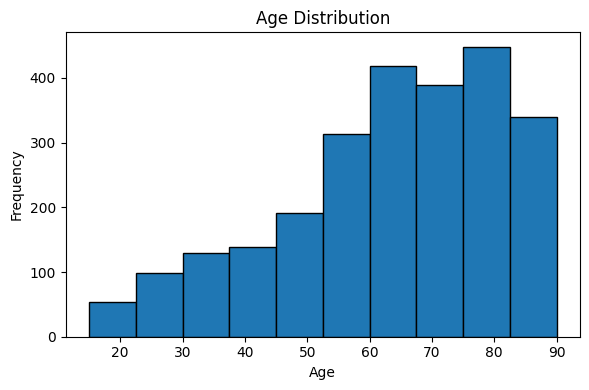

In [2]:
# Load data
data_path = '/Users/chetankumar/Library/CloudStorage/OneDrive-OldDominionUniversity/jlab_test/data/eICU_age.npy'
data = np.load(data_path)
print(f'data ===> type: {type(data)} | shape: {data.shape} | dtype: {data.dtype}')

data = data['age']
print("Min: ", data.min())
print("Max: ", data.max())
print("Mean: ", data.mean())

# Plot data distribution
plt.figure(figsize=(6, 4))
plt.hist(data, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [3]:
# Normalize data
data = data.reshape(-1, 1)

# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
data_norm = scaler.fit_transform(data.reshape(-1, 1)).astype(np.float32).flatten()

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(data_norm).shuffle(len(data_norm)).batch(128)

In [5]:
real_mean = data_norm.mean()
real_std  = data_norm.std()

In [6]:
import tensorflow as tf

class ImprovedSimpleGAN(tf.keras.Model):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # -------- Generator --------
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(1)  # linear output
        ])

        # -------- Discriminator --------
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(0.2),

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

        self.d_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
        self.g_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

    @tf.function
    def train_step(self, real_batch):
        real_batch = tf.reshape(real_batch, (-1, 1))
        batch_size = tf.shape(real_batch)[0]

        # -------- Train discriminator --------
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as d_tape:
            fake = self.generator(noise, training=True)

            real_out = self.discriminator(real_batch, training=True)
            fake_out = self.discriminator(fake, training=True)

            d_loss_real = self.loss_fn(tf.ones_like(real_out), real_out)
            d_loss_fake = self.loss_fn(tf.zeros_like(fake_out), fake_out)
            d_loss = d_loss_real + d_loss_fake

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # -------- Train generator --------
        noise = tf.random.normal((batch_size, self.latent_dim))
        with tf.GradientTape() as g_tape:
            fake = self.generator(noise, training=True)
            fake_out = self.discriminator(fake, training=True)

            g_loss = self.loss_fn(tf.ones_like(fake_out), fake_out)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return d_loss, g_loss

    # -------- Sampling --------
    def sample(self, n):
        noise = tf.random.normal((n, self.latent_dim))
        return self.generator(noise, training=False).numpy().flatten()


In [7]:
# model = Simple1DGAN(
#     latent_dim=16, 
#     real_mean=real_mean, 
#     real_std=real_std
# )
# epochs = 5000
# d_loss_list = []
# g_loss_list = []
# for epoch in range(epochs):
#     d_losses = 0
#     g_losses = 0
#     for real_batch in dataset:
#         d_loss, g_loss = model.train_step(real_batch)
#         d_losses += d_loss
#         g_losses += g_loss
#     d_loss = np.mean(d_losses)
#     g_loss = np.mean(g_losses)
#     d_loss_list.append(d_loss)
#     g_loss_list.append(g_loss)
    
#     if epoch % 200 == 0:
#         print(f"epoch:{epoch}, d_loss:{d_loss}, g_loss:{g_loss}")

In [20]:
model = ImprovedSimpleGAN(latent_dim=32)

epochs = 1500  # use 1500–3000 for best results
d_losses = []
g_losses = []

for epoch in range(epochs):
    d_sum = 0.0
    g_sum = 0.0

    for real_batch in dataset:
        d_loss, g_loss = model.train_step(real_batch)
        d_sum += float(d_loss)
        g_sum += float(g_loss)

    d_losses.append(d_sum)
    g_losses.append(g_sum)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, d_loss={d_sum:.3f}, g_loss={g_sum:.3f}")


Epoch 0, d_loss=27.196, g_loss=13.591
Epoch 200, d_loss=27.726, g_loss=13.835
Epoch 400, d_loss=27.649, g_loss=13.915
Epoch 600, d_loss=27.670, g_loss=13.894
Epoch 800, d_loss=27.636, g_loss=13.930
Epoch 1000, d_loss=27.642, g_loss=13.972
Epoch 1200, d_loss=27.693, g_loss=13.882
Epoch 1400, d_loss=27.701, g_loss=13.933


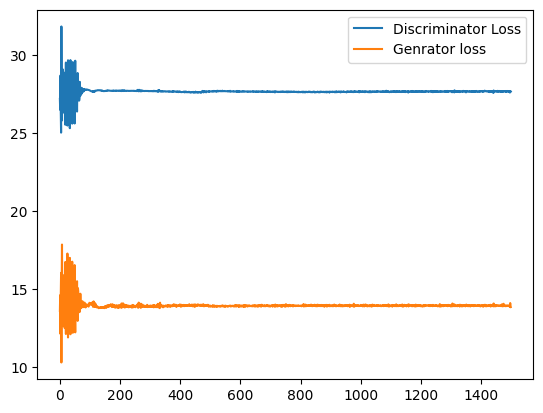

In [21]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Genrator loss')
# plt.yscale('log')
plt.legend()

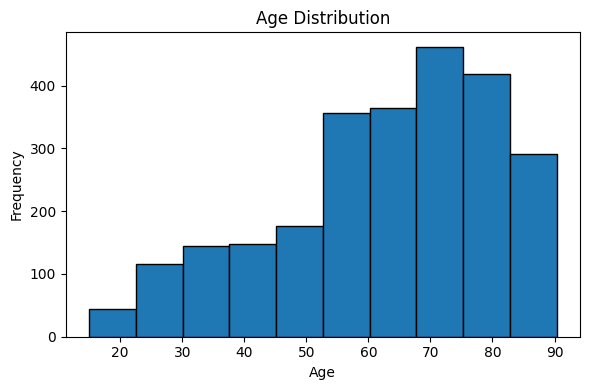

In [22]:
# Generate data
samples_scaled = model.sample(2520).reshape(-1, 1)
samples = scaler.inverse_transform(samples_scaled).flatten()
# Plot data distribution
plt.figure(figsize=(6, 4))
plt.hist(samples, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()